### Declare libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import pandas as pd
pd.set_option("display.max_columns", 30)
import numpy as np
# librerías para graficar
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="white")
import os
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import DMatrix,XGBRegressor, train

### Set folder location of the data and load data 

In [2]:
# you need to change it if you are going to run it on your local machine, writing the folder where the raw data of the challenge is
os.chdir('/Users/iairlinker/Documents/repos/cornershop_test/data')
# Loading pre-processed dataset
model_data = pd.read_csv('interim/model_data.csv', sep=';')
# Transformation for model_data
results = pd.read_csv('interim/results.csv', sep=';')

### Declare functions

In [3]:
# función creada por mi para traer los NA's
def get_na(df):
    qsna=df.shape[0]-df.isnull().sum(axis=0)
    qna=df.isnull().sum(axis=0)
    ppna=round(100*(df.isnull().sum(axis=0)/df.shape[0]),2)
    aux= {'datos sin NAs en q': qsna, 'Na en q': qna ,'Na en %': ppna}
    na=pd.DataFrame(data=aux)
    return na.sort_values(by='Na en %',ascending=False)

In [4]:
model_data.dropna(inplace=True)
get_na(model_data)

,datos sin NAs en q,Na en q,Na en %
order_id,7802,0,0.0
KG,7802,0,0.0
rating,7802,0,0.0
accepted_rate,7802,0,0.0
picking_speed,7802,0,0.0
found_rate,7802,0,0.0
seniority,7802,0,0.0
store_district,7802,0,0.0
stores_location,7802,0,0.0
stores_lng,7802,0,0.0


In [5]:
col_names = ['on_demand', 'KG', 'UN',
             'picking_speed','seniority','found_rate', 'rating',
             'order_stores_distance','order_district', 'store_district']
# 'accepted_rate'
X = model_data[col_names]
X = pd.get_dummies(X)
y = model_data.total_minutes
y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

[0]	train-aft-nloglik:12.50392
[1]	train-aft-nloglik:11.16503
[2]	train-aft-nloglik:10.08034
[3]	train-aft-nloglik:9.20142
[4]	train-aft-nloglik:8.48915
The mean squared error (MSE) on test set: 7215.3500
The mean absolute error (MAE) on test set: 77.4271


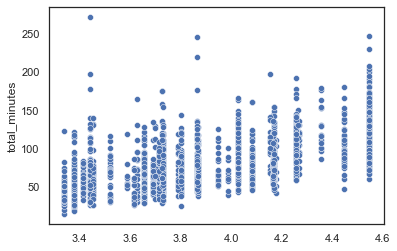

In [6]:
dtrain = DMatrix(X_train)
# This example shows each kind of censored labels.
# uncensored    right     left  interval
y_lower_bound = y_train.values
y_upper_bound = y_train.values
#np.array(np.ones(len(y_train.values)) * np.inf)
dtrain.set_float_info('label_lower_bound', y_lower_bound)
dtrain.set_float_info('label_upper_bound', y_upper_bound)
params = {'objective': 'survival:aft',
          'eval_metric': 'aft-nloglik',
          'aft_loss_distribution': 'normal',
          'aft_loss_distribution_scale': 1.20,
          'tree_method': 'hist', 'learning_rate': 0.1, 'max_depth': 3}
reg = train(params, dtrain, num_boost_round=5,
                evals=[(dtrain, 'train')])


dtest = DMatrix(X_test)
y_lower_bound = y_test.values
y_upper_bound = np.array(np.ones(len(y_test.values)) * np.inf)
dtest.set_float_info('label_lower_bound', y_lower_bound)
dtest.set_float_info('label_upper_bound', y_upper_bound)


mse = mean_squared_error(y_test, reg.predict(dtest))
mae = mean_absolute_error(y_test, reg.predict(dtest))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
print("The mean absolute error (MAE) on test set: {:.4f}".format(mae))
sns.scatterplot(y=y_test, x=reg.predict(dtest),legend=True);

count    1561.000000
mean       77.427135
std        34.945258
min        10.516341
25%        50.876835
50%        71.123261
75%        96.965815
max       268.961481
Name: total_minutes, dtype: float64


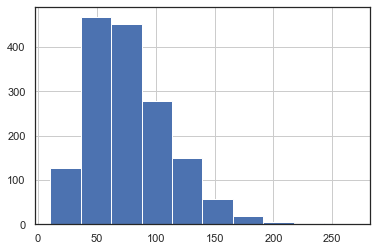

In [7]:
error = abs(reg.predict(dtest)-y_test)
print(error.describe())
error.hist();

### Suppor vector Regression using non-linear Kernels

<https://scikit-learn.org/stable/auto_examples/svm/plot_svm_regression.html>

#### Train with cross-validation to understand posible overfitting

[-9.6954212  -9.61581532 -9.6890132  -9.67716673 -9.72123089 -9.55266229
 -9.60096832 -9.52477765 -9.74119591 -9.72304986]
[-18.62066745 -19.66632335 -19.32855028 -19.20944399 -18.39682994
 -19.59604619 -19.48199005 -20.05392218 -17.57176845 -18.17130291]


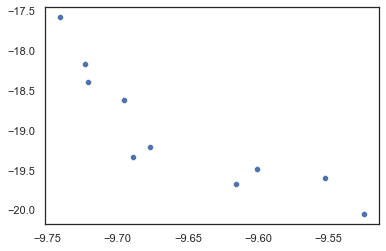

In [8]:
scores = { 'mse': "neg_mean_squared_error",
           'mae': "neg_mean_absolute_error"}

svr_rbf = SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1)

scores = cross_validate(svr_rbf , X, y, scoring=scores, cv=10,return_train_score=True)
print(scores['train_mae'])
print(scores['test_mae'])
sns.scatterplot(y=scores['test_mae'], x=scores['train_mae'],legend=True);

#### Train and test to report metrics

The mean squared error (MSE) on test set: 692.3100
The mean absolute error (MAE) on test set: 19.2198


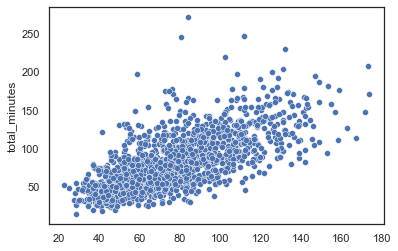

In [9]:
svr_rbf.fit(X_train, y_train)

mse = mean_squared_error(y_test, svr_rbf.predict(X_test))
mae = mean_absolute_error(y_test, svr_rbf.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
print("The mean absolute error (MAE) on test set: {:.4f}".format(mae))
sns.scatterplot(y=y_test, x=svr_rbf.predict(X_test),legend=True);

count    1561.000000
mean       19.219752
std        17.975486
min         0.004881
25%         6.749625
50%        14.648490
75%        26.614522
max       188.417406
Name: total_minutes, dtype: float64


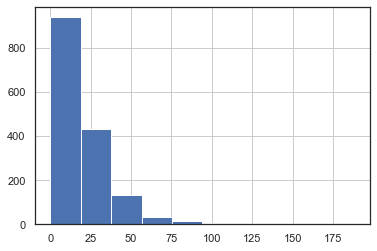

In [11]:
error = abs(svr_rbf.predict(X_test)-y_test)
print(error.describe())
error.hist();

### Gradient Boosting Regressor

<https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor>

#### train with cross-validation

[-14.80778802 -14.83154776 -14.71737661 -14.79460878 -14.79703559
 -14.80527344 -14.77446163 -14.79173502 -14.90203761 -14.82940039]
[-17.26982675 -17.78015053 -17.63320932 -18.1267115  -17.53369856
 -17.82994095 -17.79687219 -18.20756687 -16.96443718 -17.3282874 ]


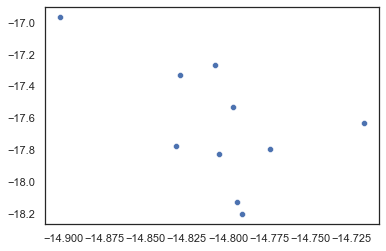

In [12]:
params = {
    "n_estimators": 500,
    "max_depth": 3,
    "min_samples_split": 10,
    "learning_rate": 0.1,
    "loss" : 'ls',
    'subsample': 0.8,
}

scores = { 'mse': "neg_mean_squared_error",
           'mae': "neg_mean_absolute_error"}


reg = GradientBoostingRegressor(**params)


scores = cross_validate(reg, X, y, scoring=scores, cv=10,return_train_score=True)
print(scores['train_mae'])
print(scores['test_mae'])
sns.scatterplot(y=scores['test_mae'], x=scores['train_mae'],legend=True);

#### train and test

0.5709748843053298
The mean squared error (MSE) on test set: 530.1802
The mean absolute error (MAE) on test set: 17.4626


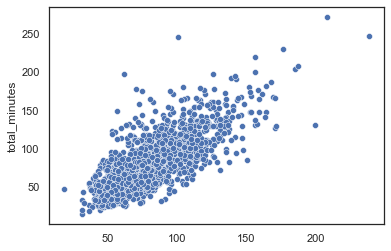

In [13]:
params = {
    "n_estimators": 500,
    "max_depth": 3,
    "min_samples_split": 10,
    "learning_rate": 0.1,
    "loss" : 'ls',
    'subsample': 0.8,
}

reg = GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

print(reg.score(X_test, y_test))
mse = mean_squared_error(y_test, reg.predict(X_test))
mae = mean_absolute_error(y_test, reg.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
print("The mean absolute error (MAE) on test set: {:.4f}".format(mae))
sns.scatterplot(y=y_test, x=reg.predict(X_test),legend=True);

count    1561.000000
mean       17.462573
std        15.012765
min         0.005119
25%         6.845771
50%        13.746371
75%        23.531553
max       145.106742
Name: total_minutes, dtype: float64


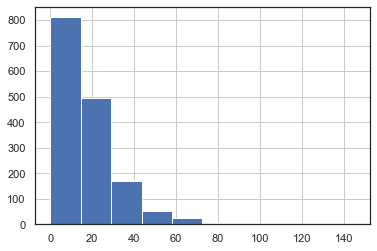

In [14]:
error = abs(reg.predict(X_test)-y_test)
print(error.describe())
error.hist();

### Scikit-Learn Interface for XGboost

Using the cost functions mae and mse  from scikit-learn out of the box

<https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html>

#### Train with cross-validation to understand posible overfitting

[-10.69748337 -10.69332522 -10.92895496 -10.65032781 -11.02333386
 -11.05960477 -10.56063958 -10.784244   -10.86141207 -11.23915661]
[-18.02081083 -18.97261603 -18.13861684 -18.84157915 -17.73800327
 -18.37177868 -18.64708591 -18.54944901 -17.34281765 -17.94991333]


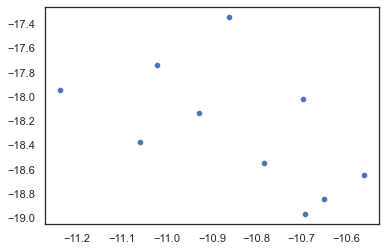

In [15]:
reg = XGBRegressor(
    tree_method="hist",
    eval_metric=mean_absolute_error,
)

scores = { 'mse': "neg_mean_squared_error",
           'mae': "neg_mean_absolute_error"}

scores = cross_validate(reg, X, y, scoring=scores, cv=10,return_train_score=True)
print(scores['train_mae'])
print(scores['test_mae'])
sns.scatterplot(y=scores['test_mae'], x=scores['train_mae'],legend=True);

#### Train and test to report metrics

[0]	validation_0-rmse:64.14143
[1]	validation_0-rmse:48.28023
[2]	validation_0-rmse:37.82820
[3]	validation_0-rmse:31.23366
[4]	validation_0-rmse:27.27267
[5]	validation_0-rmse:24.94555
[6]	validation_0-rmse:23.46649
[7]	validation_0-rmse:22.58477
[8]	validation_0-rmse:22.01865
[9]	validation_0-rmse:21.63221
[10]	validation_0-rmse:21.24611
[11]	validation_0-rmse:21.06117
[12]	validation_0-rmse:20.90301
[13]	validation_0-rmse:20.75528
[14]	validation_0-rmse:20.58266
[15]	validation_0-rmse:20.50080
[16]	validation_0-rmse:20.35388
[17]	validation_0-rmse:20.23684
[18]	validation_0-rmse:20.16239
[19]	validation_0-rmse:20.05390
[20]	validation_0-rmse:19.96025
[21]	validation_0-rmse:19.91655
[22]	validation_0-rmse:19.85406
[23]	validation_0-rmse:19.68742
[24]	validation_0-rmse:19.61109
[25]	validation_0-rmse:19.55267
[26]	validation_0-rmse:19.48035
[27]	validation_0-rmse:19.44647
[28]	validation_0-rmse:19.40529
[29]	validation_0-rmse:19.25852
[30]	validation_0-rmse:19.18152
[31]	validation_0-

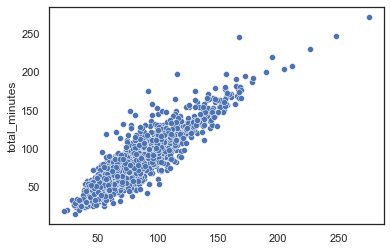

In [16]:
reg = XGBRegressor(
    tree_method="hist",
    eval_metric=mean_absolute_error,
)

reg.fit(X, y, eval_set=[(X, y)])

print(reg.score(X_test, y_test))
mse = mean_squared_error(y_test, reg.predict(X_test))
mae = mean_absolute_error(y_test, reg.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
print("The mean absolute error (MAE) on test set: {:.4f}".format(mae))
sns.scatterplot(y=y_test, x=reg.predict(X_test),legend=True);

count    1561.000000
mean       10.908196
std         9.977795
min         0.000239
25%         3.945665
50%         8.242113
75%        15.214398
max        83.611814
Name: total_minutes, dtype: float64


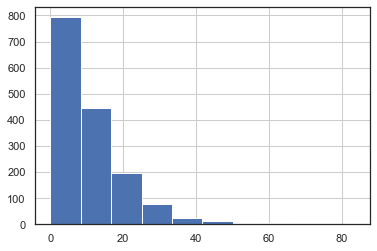

In [17]:
error = abs(reg.predict(X_test)-y_test)
print(error.describe())
error.hist();